# Experiments With Hierarchical Tasks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from progressbar import progressbar
import time

In [2]:
# This prints the output of all variables, not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# This makes plots with higher resolutions
%config InlineBackend.figure_format ='retina'
plt.rcParams["figure.figsize"] = (12,6)

light_grey = [0.8,0.8,0.8]
darker_grey = [0.6,0.6,0.6]
yellow = [1.0,1.0,0.0]
blue = [0.4,0.8,1.0]
green = [0.2,1.0,0.4]

## States and Actions

In [3]:
#from dataclasses import dataclass

# TODO Should this be a dataclass?
class State:
    """ State should be Immutable.
        States with the same variables and same values are equal and have the same hash.
    """
    def __init__(self, variables):
        ''' variables should be a dict
        '''
        for var, value in variables.items():
            setattr(self, var, value)

    def get(self):
        return dict(self.__dict__.items())

    def __str__(self):
        s = 'State('
        for key, value in self.get().items():
            s += str(key) + '=' + str(value) + ', '
        s = s[:-2] + ')'
        return s

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.get() == other.get()

    def __ne__(self, other):
        return not(self == other)
    
    def __add__(self, other):
        return State({**self.get(), **other.get()})

    def __hash__(self):
        variables = tuple([i for var in self.get().items() for i in var])
        return hash(variables)

State({'x': 5, 'y': 6})

State(y=6, x=5)

In [4]:
class Action:
    
    all_actions = {}
    
    def __init__(self, name):
        self.name = name
        self.number = Action.all_actions[name] if name in Action.all_actions else len(Action.all_actions)
        Action.all_actions[self.name] = self.number
        
    def __eq__(self, other):
        return self.number == other.number
    
    def __ne__(self, other):
        return not(self == other)
    
    def __hash__(self):
        return hash(self.number)
    
    def __str__(self):
        return 'Action: {} ({})'.format(self.name, self.number)
    
    def __repr__(self):
        return str(self)

## Grid Environment

In [5]:
class GridEnv:
    
    def __init__(self, height=10, width=10):        
        self.width, self.height = width, height

    def render(self, task=None, ax=None):
        if ax is None:
            ax = plt.gca()

        ax.clear()
        ax.title.set_text('Grid Env')

        # Plot the grid
        grid = [[ light_grey for i in range(self.width)] for j in range(self.height)]
        im = ax.imshow(grid)
        
        # Plot Connections
        #ax.plot([0, 1], [0, 2], color=darker_grey)

        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        w, h = len(grid[0]), len(grid)
        ax.set_xticks(range(w))
        ax.set_yticks(range(h))
        ax.set_xticklabels(range(w))
        ax.set_yticklabels(range(h))
        ax.set_xticks(np.arange(w+1)-.5, minor=True)
        ax.set_yticks(np.arange(h+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)
        
        if task:
            task.render(ax=ax)

env = GridEnv(8, 8)

## Navigation Task

In [6]:
class NavigationTask:
    
    def __init__(self, env, goal_pos=(1,2)):
        self.env = env
        self.goal_pos = goal_pos

        self.actions = [Action('South'), Action('North'), Action('East'), Action('West')]

        self.state_variables = ['agent_pos', 'goal_pos']
        
        self.title = 'Navigation Task'

        self.reset()
    
    def reset(self):
        self.agent_pos = [np.random.randint(0, self.env.width), np.random.randint(0, self.env.height)]
        return self.state
        
    @property
    def state(self):
        """ All variables must be hashable --> tuple, not list """
        return State({'agent_pos': tuple(self.agent_pos), 'goal_pos': tuple(self.goal_pos)})
    
    def step(self, action):
        """ South, North, East, West """
        reward = -1
        done = False
        
        if action == Action('South'):            
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.env.height - 1)
        
        elif action == Action('North'):
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        
        elif action == Action('East'):
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.env.width - 1)

        elif action == Action('West'):
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)

        if tuple(self.agent_pos) == self.goal_pos:
            reward = 0
            done = True

        # state, reward, done, info
        return self.state, reward, done

    def render(self, ax=None):
        if ax is None:
            ax = plt.gca()
        
        ax.title.set_text(self.title)
        ax.add_patch(plt.Circle(xy=self.agent_pos, radius=0.4, color=yellow))
        ax.text(self.goal_pos[0], self.goal_pos[1], 'G', fontsize=16, horizontalalignment='center', verticalalignment='center')

        
nav_task = NavigationTask(env, goal_pos=(2,1))

Actions	 [Action: South (0), Action: North (1), Action: East (2), Action: West (3)]
State	 State(agent_pos=(7, 5), goal_pos=(2, 1))


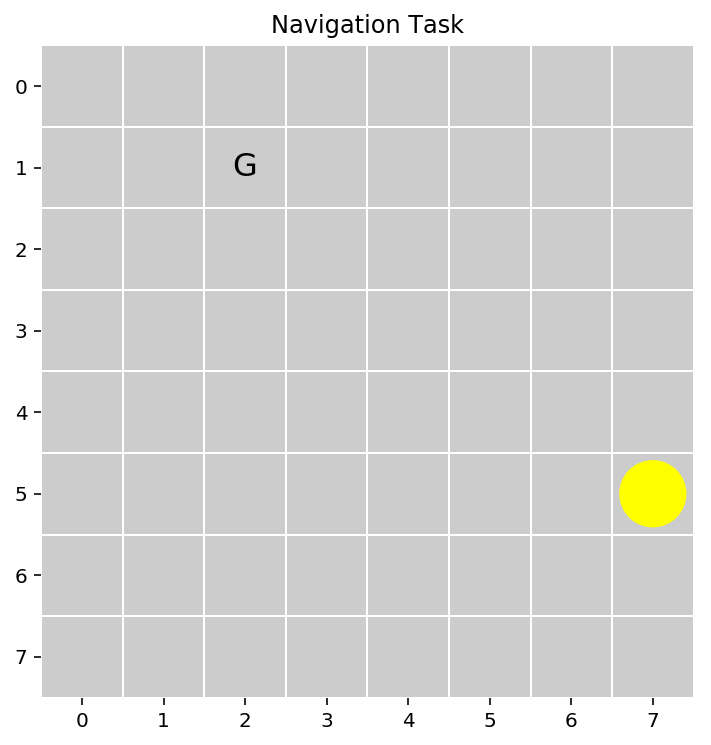

In [7]:
print('Actions\t', nav_task.actions)
print('State\t', nav_task.state)

env.render(nav_task)

## Taxi Task

In [8]:
class TaxiTask:
    
    def __init__(self, env, landmarks=[[1,1], [7,0], [2,5], [5,7]]):
        self.env = env
        self.landmarks = landmarks
        
        self.actions = [Action('South'), Action('North'), Action('East'), Action('West'),
                        Action('Pickup'), Action('Dropoff')]
        
        self.state_variables = ['passenger_pos_idx', 'passenger_goal_idx']
        
        self.title = 'Taxi World'
        
        self.reset()
        
    def reset(self):
        self.passenger_in_taxi = False
        choices = np.random.choice(len(self.landmarks), size=2, replace=False)

        self.passenger_pos = self.landmarks[choices[0]]
        self.passenger_goal_pos = self.landmarks[choices[1]]
        self.taxi_pos = [np.random.randint(0, self.env.width), np.random.randint(0, self.env.height)]

        return self.state
        
    @property
    def state(self):
        if self.passenger_in_taxi:
            passenger_pos_idx = len(self.landmarks)
        else:
            passenger_pos_idx = self.landmarks.index(self.passenger_pos)
            
        goal_idx = self.landmarks.index(self.passenger_goal_pos)

        return State({'agent_pos': self.taxi_pos, 'passenger_pos_idx': passenger_pos_idx, 'passenger_goal_idx': goal_idx})

    def step(self, action):
        reward = -1
        done = False
        
        if action == Action('South'):
            self.taxi_pos[1] = min(self.taxi_pos[1] + 1, self.env.height - 1)
        
        elif action == Action('North'):
            self.taxi_pos[1] = max(self.taxi_pos[1] - 1, 0)
        
        elif action == Action('East'):
            self.taxi_pos[0] = min(self.taxi_pos[0] + 1, self.env.width - 1)
        
        elif action == Action('West'):
            self.taxi_pos[0] = max(self.taxi_pos[0] - 1, 0)
        
        elif action == Action('Pickup'):
            if self.taxi_pos == self.passenger_pos and not self.passenger_in_taxi:
                self.passenger_in_taxi = True
            else:
                reward = -10
        
        elif action == Action('Dropoff'):
            if self.passenger_in_taxi and self.passenger_pos == self.passenger_goal_pos:
                self.passenger_in_taxi = False
                reward = 50
                done = True
            elif self.passenger_in_taxi and self.passenger_pos in self.landmarks:
                self.passenger_in_taxi = False
            else:
                reward = -10
        
        if self.passenger_in_taxi:
            self.passenger_pos = self.taxi_pos.copy()
            
        return self.state, reward, done
    
    def render(self, ax=None):
        if ax is None:
            ax = plt.gca()
        
        ax.title.set_text(self.title)
        for landmark in self.landmarks:
            ax.add_patch(plt.Circle(xy=landmark, radius=0.4, color=darker_grey))
        ax.add_patch(plt.Circle(xy=self.taxi_pos, radius=0.4, color=yellow))
        ax.add_patch(plt.Circle(xy=self.passenger_pos, radius=0.25, color=blue))
        ax.text(self.passenger_goal_pos[0], self.passenger_goal_pos[1], 'G',
                fontsize=16, horizontalalignment='center', verticalalignment='center')

Actions	 [Action: South (0), Action: North (1), Action: East (2), Action: West (3), Action: Pickup (4), Action: Dropoff (5)]
State	 State(agent_pos=[5, 0], passenger_pos_idx=3, passenger_goal_idx=1)


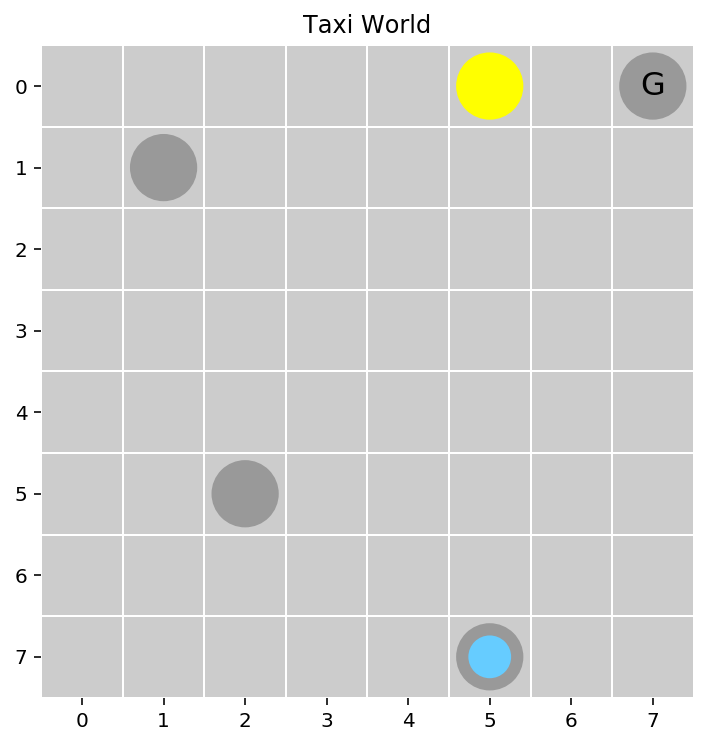

In [9]:
taxi_task = TaxiTask(env)

print('Actions\t', taxi_task.actions)
print('State\t', taxi_task.state)

env.render(taxi_task)

## How can we combine the State Spaces of Hierarchical Tasks?

In [10]:
s1 = nav_task.reset()
s1
s2 = taxi_task.reset()
s2

State(agent_pos=(6, 5), goal_pos=(2, 1))

State(agent_pos=[7, 3], passenger_pos_idx=0, passenger_goal_idx=2)

In [11]:
Q = defaultdict(lambda: {action: 0 for action in nav_task.actions})
Q[State({'0':0})][Action('North')] = 100
d = Q[State({'0':0})]
d
max(d.values())
max(d, key=d.get)

{Action: East (2): 0,
 Action: North (1): 100,
 Action: South (0): 0,
 Action: West (3): 0}

100

Action: North (1)

## Q Agent

In [12]:
class Q_Agent:
    
    def __init__(self, env, lr=0.5, gamma=0.99):
        self.env = env
        self.alpha = lr
        self.gamma = gamma  # discount
        
        self.reset()
        
    def reset(self):
        self.Q = defaultdict(lambda: {action: 0 for action in self.env.actions})
    
    def greedy_policy(self, state):
        """Returns the action with the highest Q-Value."""
        action = max(self.Q[state], key=self.Q[state].get)
        return action
    
    def exploration_policy(self, state, temperature=10):
        """Returns action according to the Gibbs distribution."""
        actions, action_vals = np.array(list(self.Q[state].keys())), np.array(list(self.Q[state].values()))
        p = np.exp(1 / temperature * action_vals)
        p /= np.sum(p)
        action = np.random.choice(actions, p=p)
        return action
    
    def update(self, state, action, next_state, reward):
        self.Q[state][action] = (1 - self.alpha) * self.Q[state][action] + self.alpha * (reward + self.gamma * max(self.Q[next_state].values()))
    
    def execute_episode(self, max_episode_len=60):
        state = self.env.reset()
        episode_reward = 0
        num_steps = 0
        done = False
        
        while not done and num_steps < max_episode_len:
            action = self.greedy_policy(state)
            next_state, reward, done = self.env.step(action)
            
            episode_reward += reward
            num_steps += 1
            
            state = next_state
        
        return episode_reward, num_steps
    
    def test_policy(self, num_runs, max_episode_len):
        avg_reward, avg_num_steps, avg_reward_per_step = [], [], []
        
        for _ in range(num_runs):
            episode_reward, num_steps = self.execute_episode(max_episode_len=max_episode_len)
            avg_reward.append(episode_reward)
            avg_num_steps.append(num_steps)
            avg_reward_per_step.append(episode_reward / num_steps)
        
        return np.mean(avg_reward), np.mean(avg_num_steps), np.mean(avg_reward_per_step)
    
    def learn(self, num_episodes, max_episode_len=300):
        global_step = 0
        training_log = defaultdict(list)
        training_log['learning_rate'] = self.alpha
        training_log['discount'] = self.gamma
        
        for episode in progressbar(range(num_episodes)):

            state = self.env.reset()
            episode_reward = 0

            for step in range(max_episode_len):

                action = self.exploration_policy(state)
                next_state, reward, done = self.env.step(action)
                self.update(state, action, next_state, reward)
                
                global_step += 1
                
                if global_step % 1000 == 0:
                    avg_reward, _, _ = self.test_policy(num_runs=100, max_episode_len=60)
                    training_log['global_training_step'].append(global_step)
                    training_log['avg_reward_per_episode'].append(avg_reward)

                if done:
                    break

                state = next_state
        
        return training_log

100% (150 of 150) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


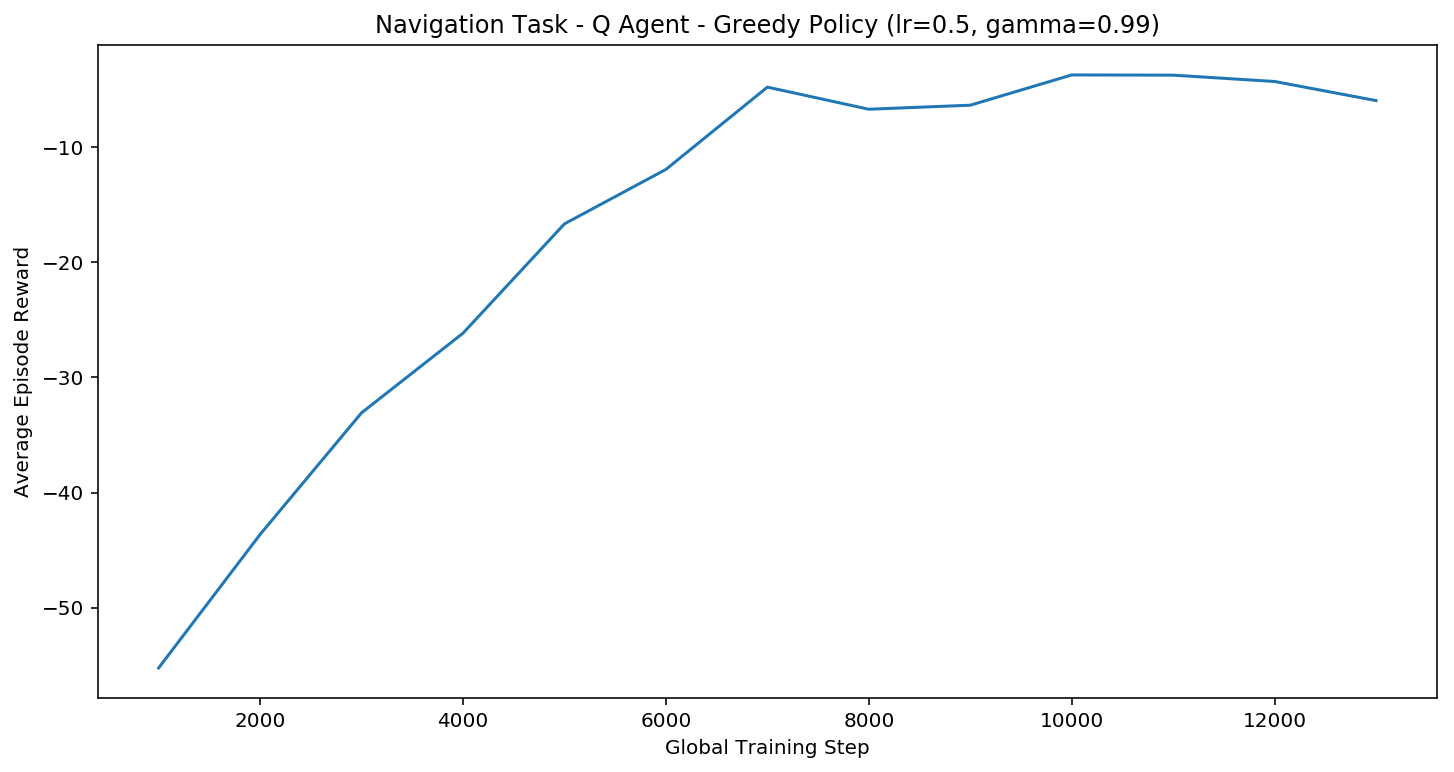

In [13]:
nav_q_agent = Q_Agent(env=nav_task)

log = nav_q_agent.learn(num_episodes=150, max_episode_len=300)

plt.plot(log['global_training_step'], log['avg_reward_per_episode']);
plt.title('{} - Q Agent - Greedy Policy (lr={}, gamma={})'.format(nav_task.title, log['learning_rate'], log['discount']));
plt.xlabel('Global Training Step');
plt.ylabel('Average Episode Reward');

## Render Task Execution

``` python
fig, ax = plt.subplots()

state = agent.env.reset()
done = False
env.render()
agent.env.render()

while not done:
    action = agent.greedy_policy(state)
    next_state, reward, done = agent.env.step(action)

    plt.cla()
    env.render()
    agent.env.render()
    plt.draw()
    plt.pause(0.1)

    state = next_state
```